##### Fetch 100 Images

In [ ]:
# import shutil
# import re
# from concurrent.futures import ThreadPoolExecutor

# # Paths
# path_real = 'Real'
# path_altered = 'Altered'
# out_real = 'NewSample-Real'
# out_altered = 'NewSample-Altered'
# subfolders = ['Altered-Easy', 'Altered-Medium', 'Altered-Hard']

# # Buat folder output
# os.makedirs(out_real, exist_ok=True)
# os.makedirs(out_altered, exist_ok=True)
# for sf in subfolders:
#     os.makedirs(os.path.join(out_altered, sf.replace('Altered-', 'NewSample-')), exist_ok=True)

# # Regex ID: ambil angka di awal sebelum "__"
# id_pattern = re.compile(r'^(\d+)__')

# def get_id(filename):
#     match = id_pattern.match(filename)
#     return int(match.group(1)) if match else None

# def copy_file(src, dst):
#     shutil.copy(src, dst)

# def copy_files_by_id_range(src_folder, dst_folder, min_id=1, max_id=100):
#     try:
#         entries = os.listdir(src_folder)
#     except FileNotFoundError:
#         return

#     # Hanya file saja
#     files = [f for f in entries if os.path.isfile(os.path.join(src_folder, f))]

#     # Ambil file dengan ID dalam rentang [1, 100]
#     filtered = []
#     for f in files:
#         file_id = get_id(f)
#         if file_id is not None and min_id <= file_id <= max_id:
#             filtered.append((file_id, f))

#     # Urut berdasarkan ID
#     filtered.sort(key=lambda x: x[0])
#     selected_files = [f for _, f in filtered]

#     # Salin paralel
#     with ThreadPoolExecutor(max_workers=16) as executor:
#         futures = []
#         for f in selected_files:
#             src = os.path.join(src_folder, f)
#             dst = os.path.join(dst_folder, f)
#             futures.append(executor.submit(copy_file, src, dst))
#         for future in futures:
#             future.result()

# # Jalankan untuk setiap folder

# # Real
# copy_files_by_id_range(path_real, out_real)

# # Altered root (jika ada file langsung)
# copy_files_by_id_range(path_altered, out_altered)

# # Altered subfolders
# for sf in subfolders:
#     src = os.path.join(path_altered, sf)
#     dst = os.path.join(out_altered, sf.replace('Altered-', 'NewSample-'))
#     copy_files_by_id_range(src, dst)

# **Pre-processing**

In [ ]:
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [ ]:

def process_and_save_image(img_path, save_dir, show=False):
    img = cv.imread(img_path)

    # Konversi ke grayscale
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # CLAHE untuk meningkatkan kontras lokal ridge
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # Kernel morfologi kecil untuk presisi detail
    kernel = np.ones((2, 2), np.uint8)

    # Morfologi: Dilasi → Erosi → Closing
    dilated = cv.dilate(enhanced, kernel, iterations=1)
    eroded = cv.erode(dilated, kernel, iterations=1)
    closed = cv.morphologyEx(eroded, cv.MORPH_CLOSE, kernel)

    os.makedirs(save_dir, exist_ok=True)
    base_name = os.path.basename(img_path)
    name_wo_ext = os.path.splitext(base_name)[0]
    save_path = os.path.join(save_dir, f"{name_wo_ext}_processed.png")
    cv.imwrite(save_path, closed)

    if show:
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 4, 1), plt.imshow(gray, cmap='gray'), plt.title("Grayscale"), plt.axis("off")
        plt.subplot(1, 4, 2), plt.imshow(enhanced, cmap='gray'), plt.title("CLAHE Enhanced"), plt.axis("off")
        plt.subplot(1, 4, 3), plt.imshow(eroded, cmap='gray'), plt.title("Erosion"), plt.axis("off")
        plt.subplot(1, 4, 4), plt.imshow(closed, cmap='gray'), plt.title("Final (Closed)"), plt.axis("off")
        plt.tight_layout()
        plt.show()

# Folder - Input
base_real = "NewSample-Real"
base_altered = "NewSample-Altered"

# Folder - Output: Real & Altered
output_base = "Processed-Output"
output_real = os.path.join(output_base, "real")
output_altered = os.path.join(output_base, "altered")

# REAL
for filename in os.listdir(base_real):
    if filename.lower().endswith(".bmp"):
        img_path = os.path.join(base_real, filename)
        process_and_save_image(img_path, output_real)

# ALTERED
difficulty_map = {
    "NewSample-Easy": "easy",
    "NewSample-Medium": "medium",
    "NewSample-Hard": "hard"
}

for folder_name, difficulty in difficulty_map.items():
    folder_path = os.path.join(base_altered, folder_name)
    output_folder = os.path.join(output_altered, difficulty)
    
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".bmp"):
            img_path = os.path.join(folder_path, filename)
            process_and_save_image(img_path, output_folder)

# **Ekstraksi Fitur**

### Ektraksi Fitur Gabor

In [ ]:
from scipy.stats import entropy
from skimage import img_as_ubyte
import random

# 🔐 Set seed global
np.random.seed(42)
random.seed(42)

# ========== PARAMETER ==========
orientations = [0, np.pi/4, np.pi/2, 3*np.pi/4]
lambdas = [np.pi/4, np.pi/2, 3*np.pi/4]
sigma = 3
gamma_main = 0.5
gamma_extra = 0.05
phi = 0

def extract_gabor_features(img_path):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    if img is None:
        return None

    # 🔁 Optional resize agar konsisten dengan CNN
    img = cv.resize(img, (96, 103), interpolation=cv.INTER_AREA)

    # 🧽 Pastikan format uint8
    img = np.clip(img, 0, 255).astype(np.uint8)
    img = img_as_ubyte(img)

    feature_vector = []

    def get_entropy(flattened):
        hist, _ = np.histogram(flattened.astype(np.float32), bins=256, range=(0, 255), density=True)
        return entropy(hist + 1e-5, base=2)

    def get_features(filtered):
        flat = filtered.flatten()
        return [
            get_entropy(flat),
            np.std(flat),
            np.sum(flat ** 2),
            np.mean(flat)
        ]

    # Kombinasi Gabor
    main_combinations = [(t, l, gamma_main) for t in orientations for l in lambdas]
    extra_combinations = [(t, l, gamma_extra) for t in orientations[:2] for l in lambdas]

    for theta, lamda, gamma in main_combinations + extra_combinations:
        ksize = int(8 * sigma + 1)
        kernel = cv.getGaborKernel((ksize, ksize), sigma, theta, lamda, gamma, phi, ktype=cv.CV_32F)
        filtered = cv.filter2D(img, cv.CV_8UC1, kernel)
        feature_vector.extend(get_features(filtered))

    return feature_vector

In [5]:
# ======================= REAL & ALTERED ===========================
base_dir = 'Processed-Output'
real_dir = os.path.join(base_dir, 'real')
altered_dirs = {
    'easy': os.path.join(base_dir, 'altered', 'easy'),
    'medium': os.path.join(base_dir, 'altered', 'medium'),
    'hard': os.path.join(base_dir, 'altered', 'hard')
}

# REAL
data_real = []
for filename in os.listdir(real_dir):
    if filename.lower().endswith('.png'):
        img_path = os.path.join(real_dir, filename)
        features = extract_gabor_features(img_path)
        if features is not None:
            data_real.append([filename] + features)

df_real_gabor = pd.DataFrame(data_real, columns=['filename'] + [f'gabor_feat_{i+1}' for i in range(72)])
print("✅ Ekstraksi Gabor untuk NewSample-Real selesai.")

# ALTERED
data_altered = []
for label, folder in altered_dirs.items():
    for filename in os.listdir(folder):
        if filename.lower().endswith('.png'):
            img_path = os.path.join(folder, filename)
            features = extract_gabor_features(img_path)
            if features is not None:
                data_altered.append([filename, label] + features)

df_altered_gabor = pd.DataFrame(data_altered, columns=['filename', 'difficulty'] + [f'gabor_feat_{i+1}' for i in range(72)])
print("✅ Ekstraksi Gabor untuk NewSample-Altered selesai.")

df_real_gabor.to_csv('Gabor_features_real.csv', index=False)
df_altered_gabor.to_csv('Gabor_features_altered.csv', index=False)

print("📁 Fitur disimpan sebagai:")
print("    → Gabor_features_real.csv")
print("    → Gabor_features_altered.csv")

✅ Ekstraksi Gabor untuk NewSample-Real selesai.
✅ Ekstraksi Gabor untuk NewSample-Altered selesai.
📁 Fitur disimpan sebagai:
    → Gabor_features_real.csv
    → Gabor_features_altered.csv


### Ekstraksi Fitur CNN

In [ ]:
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import random
from tqdm import tqdm

# ======== 1. SET SEED DETERMINISTIK ========
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ======== 2. DEFINISI ARSITEKTUR CNN ========
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )

        dummy = torch.zeros(1, 1, 103, 96)
        dummy_out = self.features(dummy)
        self.flat_size = dummy_out.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flat_size, 4096),
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# ======== 3. LOAD MODEL DAN KONFIG DEVICE ========
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN().to(device)
torch.save(model.state_dict(), 'CustomCNN_FeatureExtractor.pth')  # hanya jika belum pernah disimpan
print("✅ CustomCNN_FeatureExtractor.pth selesai disimpan")
model.load_state_dict(torch.load("CustomCNN_FeatureExtractor.pth", map_location=device))
model.eval()

# ======== 4. PARAMETER & TRANSFORM =========
img_size = (96, 103)
batch_size = 32
transform = transforms.ToTensor()

✅ CustomCNN_FeatureExtractor.pth selesai disimpan


In [9]:
# ======================= FUNGSI EKSTRAKSI BATCH ===========================
def load_and_preprocess_images(filepaths):
    images = []
    valid_filenames = []
    for path in filepaths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        img_tensor = transform(img)
        images.append(img_tensor)
        valid_filenames.append(os.path.basename(path))
    if not images:
        return None, None
    batch = torch.stack(images).to(device)
    return batch, valid_filenames

def extract_features_from_folder(folder_path, label=None):
    if not os.path.exists(folder_path):
        print(f"⚠️ Folder tidak ditemukan: {folder_path}")
        return []

    file_list = [f for f in os.listdir(folder_path) if f.lower().endswith('.png')]
    if not file_list:
        print(f"⚠️ Folder kosong atau tidak ada file PNG: {folder_path}")
        return []

    all_features = []
    for i in tqdm(range(0, len(file_list), batch_size), desc=f"Ekstraksi CNN: {label or 'real'}"):
        batch_files = file_list[i:i + batch_size]
        full_paths = [os.path.join(folder_path, f) for f in batch_files]
        batch_tensor, valid_names = load_and_preprocess_images(full_paths)
        if batch_tensor is None:
            continue
        with torch.no_grad():
            outputs = model(batch_tensor).cpu().numpy()
        for name, feat in zip(valid_names, outputs):
            row = [name, label] + feat.tolist() if label is not None else [name] + feat.tolist()
            all_features.append(row)
    return all_features

# ======================= REAL & ALTERED ===========================
base_dir = 'Processed-Output'
real_dir = os.path.join(base_dir, 'real')
altered_dirs = {
    'easy': os.path.join(base_dir, 'altered', 'easy'),
    'medium': os.path.join(base_dir, 'altered', 'medium'),
    'hard': os.path.join(base_dir, 'altered', 'hard')
}

# REAL
features_real = extract_features_from_folder(real_dir)
if features_real:
    df_real = pd.DataFrame(features_real, columns=['filename'] + [f'cnn_feat_{i+1}' for i in range(4096)])
    df_real.to_csv('CNN_features_real.csv', index=False)
    print("✅ CNN_features_real.csv selesai disimpan.")

# ALTERED
features_altered = []
for label, path in altered_dirs.items():
    feats = extract_features_from_folder(path, label=label)
    features_altered.extend(feats)

if features_altered:
    df_altered = pd.DataFrame(features_altered, columns=['filename', 'difficulty'] + [f'cnn_feat_{i+1}' for i in range(4096)])
    df_altered.to_csv('CNN_features_altered.csv', index=False)
    print("✅ CNN_features_altered.csv selesai disimpan.")

Ekstraksi CNN: real: 100%|██████████| 32/32 [00:02<00:00, 11.18it/s]


✅ CNN_features_real.csv selesai disimpan.


Ekstraksi CNN: hard: 100%|██████████| 76/76 [00:08<00:00,  8.59it/s]


✅ CNN_features_altered.csv selesai disimpan.


In [10]:
dfgabor = pd.read_csv('Gabor_features_altered.csv')
dfcnn = pd.read_csv('CNN_features_altered.csv')

print(dfgabor['difficulty'].value_counts())
print(dfcnn['difficulty'].value_counts())

difficulty
easy      2976
medium    2845
hard      2402
Name: count, dtype: int64
difficulty
easy      2976
medium    2845
hard      2402
Name: count, dtype: int64


### Gabor + CNN (Feature Fusion)

In [ ]:
df_gabor_real = pd.read_csv("Gabor_features_real.csv")
df_cnn_real = pd.read_csv("CNN_features_real.csv")

df_gabor_altered = pd.read_csv("Gabor_features_altered.csv")
df_cnn_altered = pd.read_csv("CNN_features_altered.csv")

# 🔷 Fusion untuk REAL - filename
df_real_fused = pd.merge(df_gabor_real, df_cnn_real, on="filename", how='inner')

# Label ID
df_real_fused['ID'] = df_real_fused['filename'].apply(lambda x: x.split('__')[0])

# REAL
df_real_fused.to_csv("Fusion_features_real.csv", index=False)
print("✅ Fitur fusion REAL selesai → Fusion_features_real.csv")

# 🔶 Fusion untuk ALTERED - filename & difficulty
df_altered_fused = pd.merge(df_gabor_altered, df_cnn_altered, on=["filename", "difficulty"], how='inner')

# Label ID
df_altered_fused['ID'] = df_altered_fused['filename'].apply(lambda x: x.split('__')[0])

# ALTERED
df_altered_fused.to_csv("Fusion_features_altered.csv", index=False)
print("✅ Fitur fusion ALTERED selesai → Fusion_features_altered.csv")

✅ Fitur fusion REAL selesai → Fusion_features_real.csv
✅ Fitur fusion ALTERED selesai → Fusion_features_altered.csv


In [13]:
# 'ID' Integer
df_real_fused['ID'] = df_real_fused['ID'].astype(int)
df_altered_fused['ID'] = df_altered_fused['ID'].astype(int)

real_ids_unique = sorted(df_real_fused['ID'].unique())
altered_ids_unique = sorted(df_altered_fused['ID'].unique())

print(f"ID Real unik terurut: [{real_ids_unique[0]}, ..., {real_ids_unique[-1]}]")
print(f"Jumlah baris di df_real_fused: {len(df_real_fused)}")
print(f"Jumlah unik ID di df_real_fused: {len(real_ids_unique)}\n")

print(f"ID Altered unik terurut: [{altered_ids_unique[0]}, ..., {altered_ids_unique[-1]}]")
print(f"Jumlah baris di df_altered_fused: {len(df_altered_fused)}")
print(f"Jumlah unik ID di df_altered_fused: {len(altered_ids_unique)}\n")

if 'difficulty' in df_altered_fused.columns:
    print("Distribusi nilai difficulty di df_altered_fused:")
    print(df_altered_fused['difficulty'].value_counts())
else:
    print("Kolom 'difficulty' TIDAK ditemukan di df_altered_fused!")

ID Real unik terurut: [1, ..., 100]
Jumlah baris di df_real_fused: 1000
Jumlah unik ID di df_real_fused: 100

ID Altered unik terurut: [1, ..., 100]
Jumlah baris di df_altered_fused: 8223
Jumlah unik ID di df_altered_fused: 100

Distribusi nilai difficulty di df_altered_fused:
difficulty
easy      2976
medium    2845
hard      2402
Name: count, dtype: int64


# **Klasifikasi**

### **SVM**

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

##### Gabungan (Easy, Medium, Hard): SVM + with PCA (250 Components) - Feature Fusion

📊 Variansi otal yang dijelaskan oleh 250 komponen PCA: 0.9477
Test accuracy (PCA + SVM): 0.6777
Classification Report (PCA + SVM):
              precision    recall  f1-score   support

           1       0.88      0.76      0.81        87
           2       0.98      0.64      0.77        86
           3       0.60      0.70      0.65        88
           4       0.79      0.56      0.65        81
           5       0.87      0.60      0.71        86
           6       0.74      0.73      0.73        77
           7       1.00      0.60      0.75        80
           8       0.89      0.67      0.76        87
           9       1.00      0.61      0.76        80
          10       0.93      0.67      0.78        85
          11       0.82      0.70      0.76        87
          12       0.59      0.79      0.68        82
          13       0.93      0.69      0.79        78
          14       0.55      0.68      0.61        85
          15       0.75      0.70      0.72        77
    

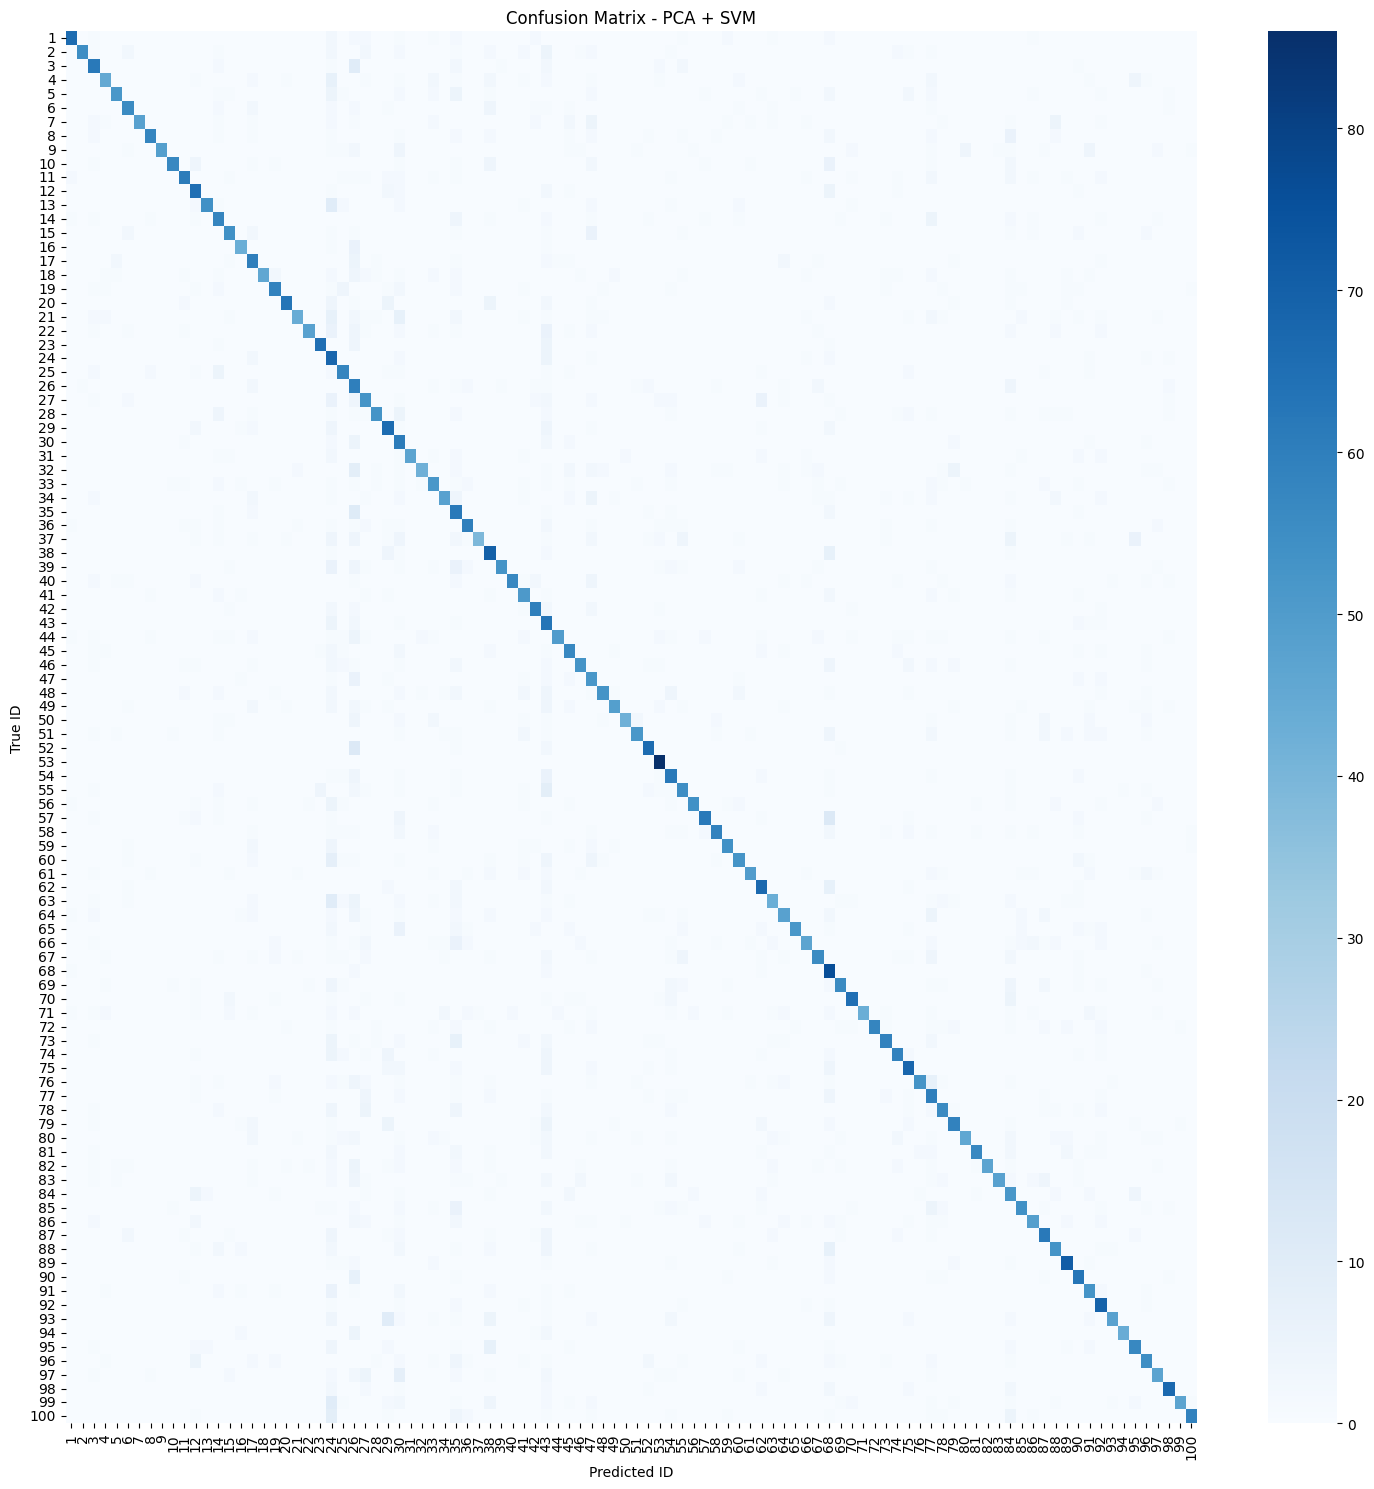

In [15]:
df_train = pd.read_csv("Fusion_features_real.csv")
df_test = pd.read_csv("Fusion_features_altered.csv")

# Fitur & Label
X_train = df_train.drop(columns=["filename", "ID"])
y_train = df_train["ID"]

X_test = df_test.drop(columns=["filename", "difficulty", "ID"])
y_test = df_test["ID"]

# 🔧 Standarisasi Fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔢 PCA
n_components = 250
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"📊 Variansi otal yang dijelaskan oleh {n_components} komponen PCA: {pca.explained_variance_ratio_.sum():.4f}")

df_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components)])
df_train_pca['ID'] = y_train.values
df_train_pca.to_csv("Train_PCA_SVM.csv", index=False)

df_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(n_components)])
df_test_pca['ID'] = y_test.values
df_test_pca.to_csv("Test_PCA_SVM.csv", index=False)

# ======================= Parameter SVM Model 🧠 ===========================
model = SVC(C=10, kernel='rbf', gamma='auto')

model.fit(X_train_pca, y_train)

# 🔮 Prediksi
y_pred = model.predict(X_test_pca)

# 🎯 Evaluasi
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy (PCA + SVM): {acc:.4f}")

# ======================= Classification Report ===========================
print("Classification Report (PCA + SVM):")
print(classification_report(y_test, y_pred))

# ✅ Benar / ❌ Salah
correct = (y_pred == y_test).sum()
incorrect = (y_pred != y_test).sum()
print(f"✅ Jumlah prediksi benar: {correct}")
print(f"❌ Jumlah prediksi salah: {incorrect}")

plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.xlabel("Predicted ID")
plt.ylabel("True ID")
plt.title("Confusion Matrix - PCA + SVM")
plt.tight_layout()
plt.show()

##### without Feature Fusion


📊 [PCA + SVM (Gabor Features)] Variansi total oleh 15 komponen PCA: 0.9712
Test accuracy (PCA + SVM (Gabor Features)): 0.5340
✅ Jumlah prediksi benar: 4391
❌ Jumlah prediksi salah: 3832

📊 [PCA + SVM (CNN Features)] Variansi total oleh 250 komponen PCA: 0.9496
Test accuracy (PCA + SVM (CNN Features)): 0.6641
✅ Jumlah prediksi benar: 5461
❌ Jumlah prediksi salah: 2762


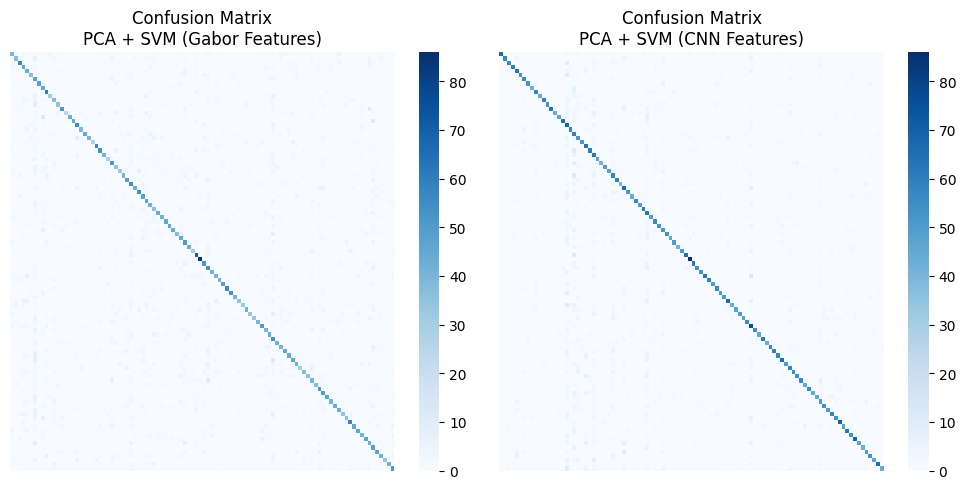

In [ ]:
def load_and_prepare_data(feature_type):
    df_train = pd.read_csv(f"{feature_type}_features_real.csv")
    df_test = pd.read_csv(f"{feature_type}_features_altered.csv")

    df_train["ID"] = df_train["filename"].apply(lambda x: x.split("__")[0])
    df_test["ID"] = df_test["filename"].apply(lambda x: x.split("__")[0])

    X_train = df_train.drop(columns=["filename", "ID"])
    y_train = df_train["ID"]

    X_test = df_test.drop(columns=["filename", "difficulty", "ID"])
    y_test = df_test["ID"]

    return X_train, y_train, X_test, y_test

def train_evaluate_plot(X_train, y_train, X_test, y_test, n_components, title, subplot_index):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    print(f"\n📊 [{title}] Variansi total oleh {n_components} komponen PCA: {pca.explained_variance_ratio_.sum():.4f}")

    # SVM Model
    model = SVC(C=10, kernel='rbf', gamma='auto')
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"Test accuracy ({title}): {acc:.4f}")
    correct = (y_pred == y_test).sum()
    incorrect = (y_pred != y_test).sum()
    print(f"✅ Jumlah prediksi benar: {correct}")
    print(f"❌ Jumlah prediksi salah: {incorrect}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
    ax = plt.subplot(1, 2, subplot_index)
    sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=False, yticklabels=False, ax=ax)
    ax.set_title(f"Confusion Matrix\n{title}")

# Gabor
X_train_gabor, y_train_gabor, X_test_gabor, y_test_gabor = load_and_prepare_data("gabor")

# CNN
X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn = load_and_prepare_data("CNN")

plt.figure(figsize=(10, 5))
train_evaluate_plot(
    X_train_gabor, y_train_gabor, X_test_gabor, y_test_gabor,
    n_components=15,
    title="PCA + SVM (Gabor Features)",
    subplot_index=1
)

train_evaluate_plot(
    X_train_cnn, y_train_cnn, X_test_cnn, y_test_cnn,
    n_components=250,
    title="PCA + SVM (CNN Features)",
    subplot_index=2
)
plt.tight_layout()
plt.show()

##### Easy

📊 Variansi total yang dijelaskan oleh 250 komponen PCA: 0.9478

🎯 Akurasi Test (PCA + SVM, easy only): 0.9614

📋 Classification Report:
              precision    recall  f1-score   support

           1       0.97      1.00      0.98        30
           2       1.00      0.97      0.98        30
           3       0.97      0.97      0.97        30
           4       1.00      0.97      0.98        30
           5       1.00      1.00      1.00        30
           6       1.00      0.97      0.98        30
           7       1.00      0.93      0.96        29
           8       1.00      0.97      0.98        30
           9       1.00      0.97      0.98        30
          10       1.00      0.97      0.98        30
          11       1.00      0.97      0.98        30
          12       0.91      0.97      0.94        30
          13       1.00      0.93      0.97        30
          14       1.00      0.97      0.98        30
          15       1.00      0.97      0.98        30

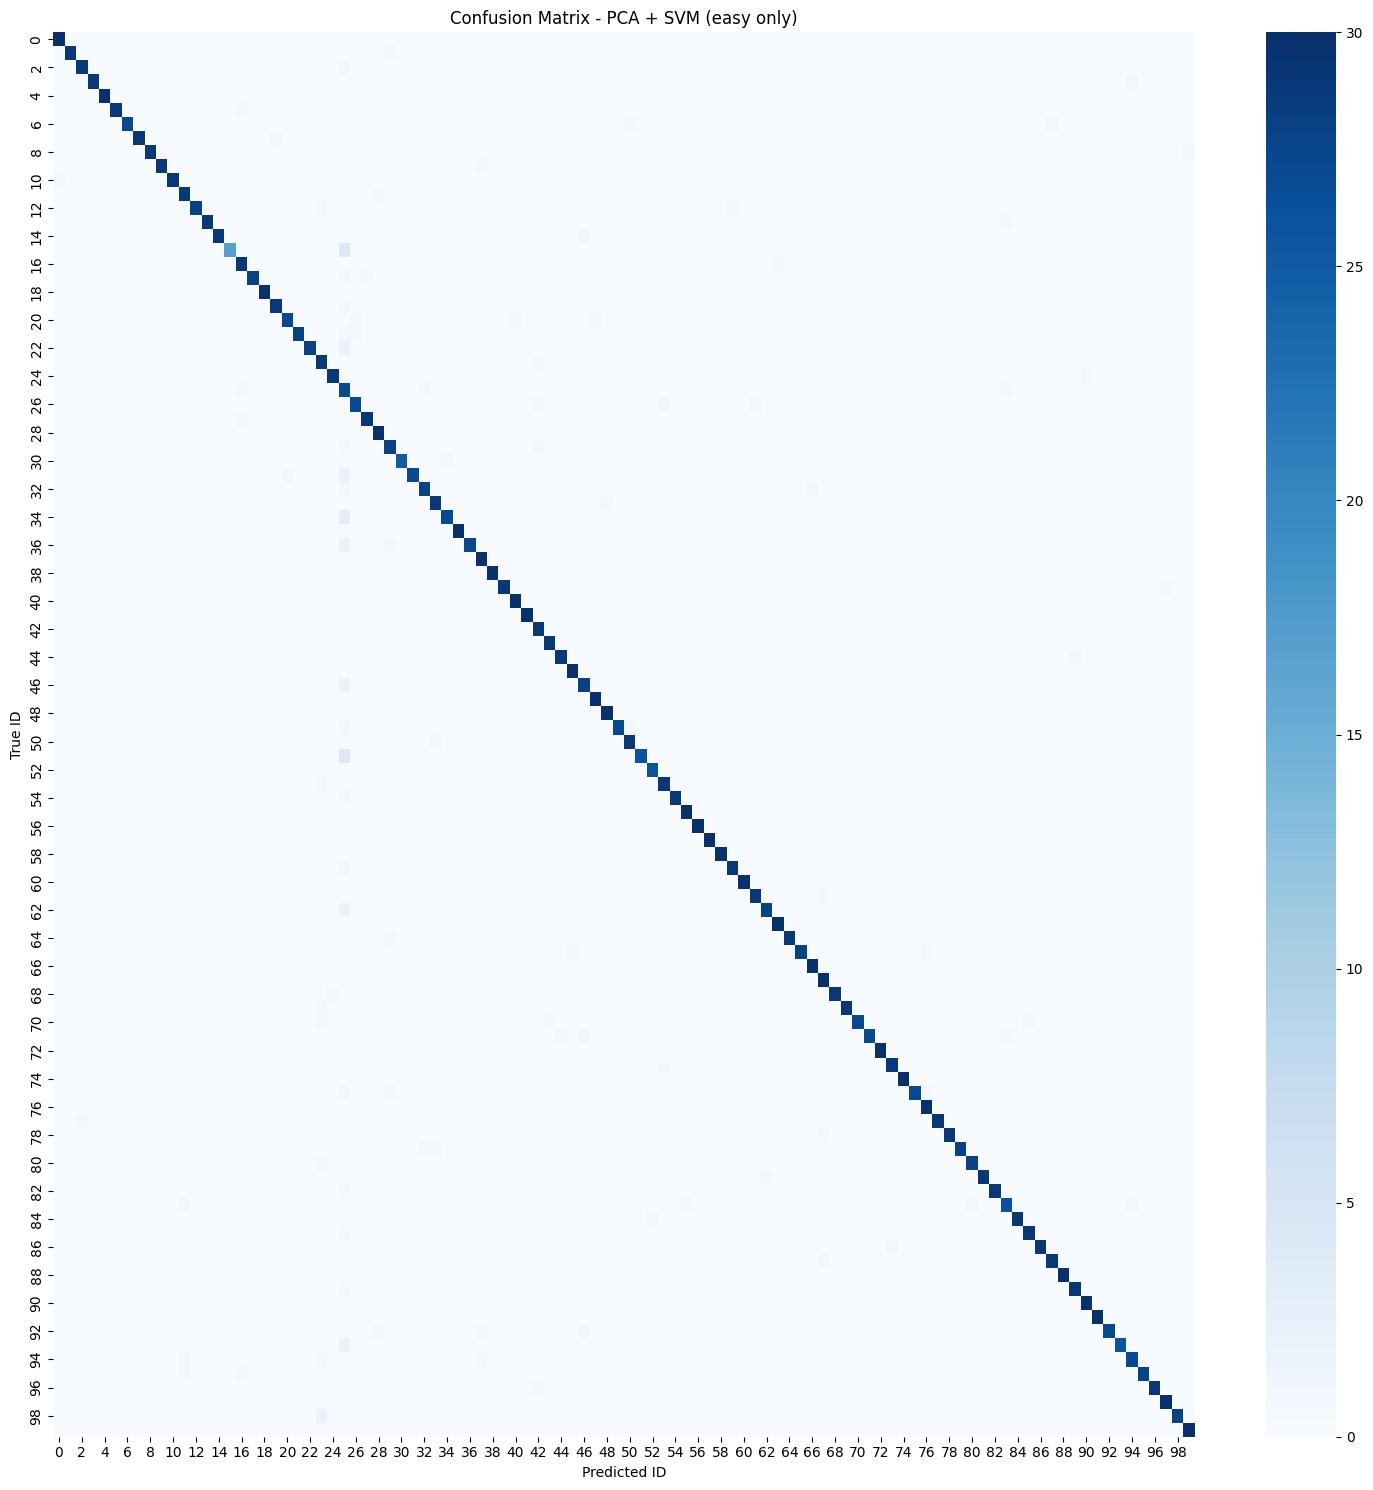

In [ ]:
df_train = pd.read_csv("Fusion_features_real.csv")
df_test = pd.read_csv("Fusion_features_altered.csv")

df_test_easy = df_test[df_test["difficulty"] == "easy"].copy()

X_train = df_train.drop(columns=["filename", "ID"])
y_train = df_train["ID"]

X_test = df_test_easy.drop(columns=["filename", "difficulty", "ID"])
y_test = df_test_easy["ID"]

###

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

n_components = 250
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"📊 Variansi total yang dijelaskan oleh {n_components} komponen PCA: {pca.explained_variance_ratio_.sum():.4f}")

# df_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components)])
# df_train_pca['ID'] = y_train.values
# df_train_pca.to_csv("Train_PCA_easy.csv", index=False)

# df_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(n_components)])
# df_test_pca['ID'] = y_test.values
# df_test_pca.to_csv("Test_PCA_easy.csv", index=False)

###

model = SVC(C=10, kernel='rbf', gamma='auto')
model.fit(X_train_pca, y_train)

y_pred = model.predict(X_test_pca)

acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Akurasi Test (PCA + SVM, easy only): {acc:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

correct = (y_pred == y_test).sum()
incorrect = (y_pred != y_test).sum()
print(f"✅ Jumlah prediksi benar: {correct}")
print(f"❌ Jumlah prediksi salah: {incorrect}")

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title("Confusion Matrix - PCA + SVM (easy only)")
plt.xlabel("Predicted ID")
plt.ylabel("True ID")
plt.tight_layout()
plt.show()

##### **Save Model: Easy**

In [25]:
import joblib

# 💾 Simpan Model Komponen
joblib.dump({
    'scaler': scaler,
    'pca': pca,
    'model': model
}, 'SVM_Fingerprint_Model.joblib')

print("✅ Model pipeline saved to 'SVM_Fingerprint_Model.joblib'")

✅ Model pipeline saved to 'SVM_Fingerprint_Model.joblib'


In [26]:
# 🔄 Hasil Prediksi
df_result = df_test_easy[["filename", "ID"]].copy()
df_result["Predicted_ID"] = y_pred

df_result.to_csv("Prediction_Results_easy.csv", index=False)

print("✅ Hasil prediksi disimpan ke 'Prediction_Results_easy.csv'")

✅ Hasil prediksi disimpan ke 'Prediction_Results_easy.csv'


In [27]:
# ✅ Hitung benar/salah per sampel
comparison = y_pred == y_test

correct = np.sum(comparison)
incorrect = np.sum(~comparison)

accuracy = correct / len(y_test)

print(f"\n✅ Jumlah prediksi benar: {correct}")
print(f"❌ Jumlah prediksi salah: {incorrect}")
print(f"🎯 Akurasi validasi: {accuracy:.4f}")


✅ Jumlah prediksi benar: 2861
❌ Jumlah prediksi salah: 115
🎯 Akurasi validasi: 0.9614


In [28]:
df_result["is_correct"] = df_result["ID"] == df_result["Predicted_ID"]
df_result.to_csv("prediction_results_easy.csv", index=False)

df_incorrect = df_result[df_result["is_correct"] == False]

print("\n🔍 Contoh prediksi yang salah:")
print(df_incorrect.head())


🔍 Contoh prediksi yang salah:
                                        filename  ID  Predicted_ID  is_correct
31     10__M_Left_index_finger_Obl_processed.png  10            38       False
67    11__M_Left_middle_finger_Obl_processed.png  11             1       False
94    12__M_Left_little_finger_Obl_processed.png  12            29       False
121    13__F_Left_index_finger_Obl_processed.png  13            60       False
139  13__F_Right_little_finger_Obl_processed.png  13            24       False


##### Gabungan + No PCA

Akurasi terhadap Test Data: 0.5767
Classification Report:
              precision    recall  f1-score   support

           1       0.80      0.55      0.65        87
           2       0.84      0.37      0.52        86
           3       0.48      0.61      0.54        88
           4       0.78      0.44      0.57        81
           5       0.57      0.52      0.55        86
           6       0.86      0.70      0.77        77
           7       1.00      0.44      0.61        80
           8       0.81      0.53      0.64        87
           9       0.96      0.54      0.69        80
          10       0.88      0.53      0.66        85
          11       0.93      0.64      0.76        87
          12       0.32      0.74      0.45        82
          13       0.77      0.59      0.67        78
          14       0.63      0.52      0.57        85
          15       0.83      0.62      0.71        77
          16       0.68      0.82      0.74        51
          17       0.72

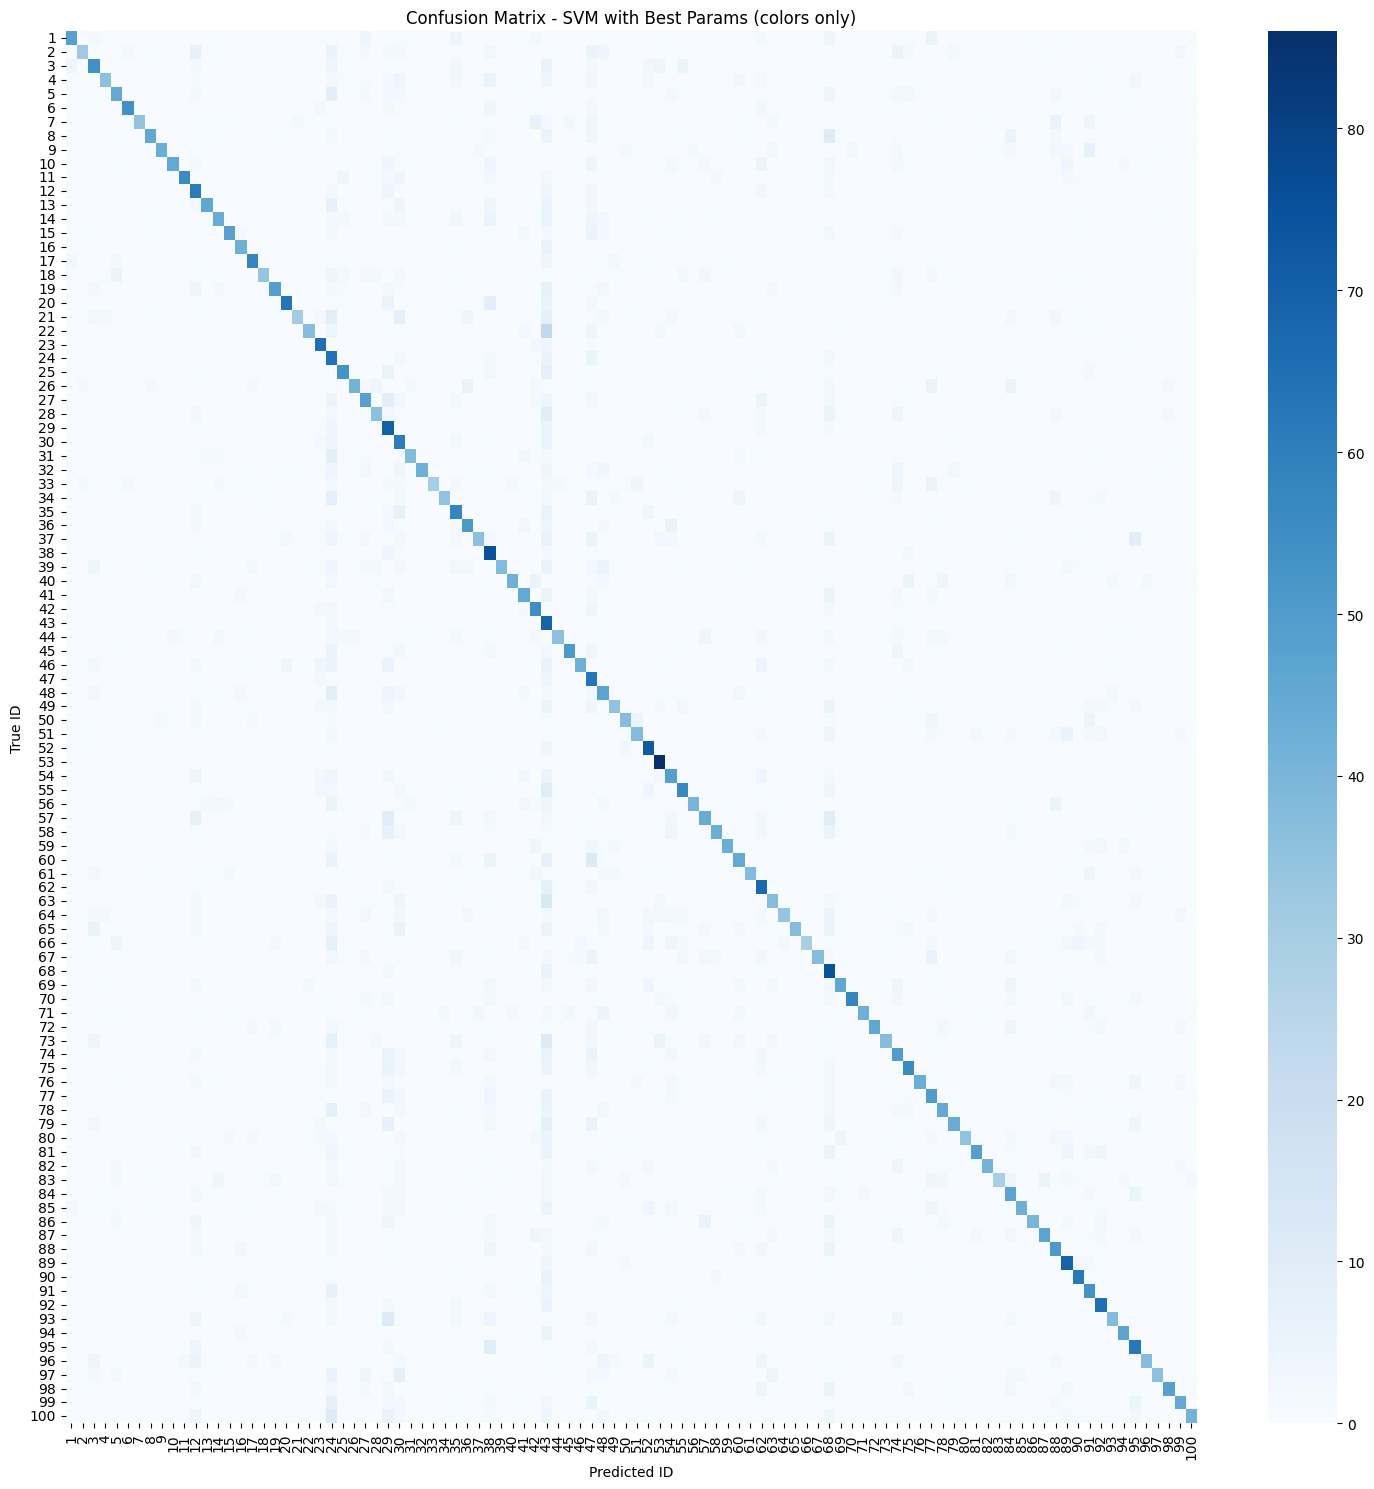

In [22]:
df_train = pd.read_csv("Fusion_features_real.csv")
df_test = pd.read_csv("Fusion_features_altered.csv")

X_train = df_train.drop(columns=["filename", "ID"])
y_train = df_train["ID"]

X_test = df_test.drop(columns=["filename", "difficulty", "ID"])
y_test = df_test["ID"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model
model = SVC(C=10, kernel='rbf', gamma='auto')

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f"Akurasi terhadap Test Data: {acc:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

correct = (y_pred == y_test).sum()
incorrect = (y_pred != y_test).sum()
print(f"Jumlah prediksi benar: {correct}")
print(f"Jumlah prediksi salah: {incorrect}")

plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.xlabel("Predicted ID")
plt.ylabel("True ID")
plt.title("Confusion Matrix - SVM with Best Params (colors only)")
plt.tight_layout()
plt.show()

### **RandomForest**

##### Gabungan (Easy, Medium, Hard): RF + with PCA (250 Components)

📊 Variansi otal yang dijelaskan oleh 250 komponen PCA: 0.9478
Test accuracy (PCA + Random Forest): 0.3971
Classification Report (PCA + Random Forest):
              precision    recall  f1-score   support

           1       0.40      0.34      0.37        87
           2       0.44      0.31      0.36        86
           3       0.22      0.53      0.31        88
           4       0.28      0.36      0.31        81
           5       0.37      0.38      0.38        86
           6       0.44      0.44      0.44        77
           7       0.45      0.34      0.39        80
           8       0.44      0.39      0.41        87
           9       0.53      0.49      0.51        80
          10       0.34      0.29      0.32        85
          11       0.59      0.47      0.52        87
          12       0.18      0.46      0.25        82
          13       0.29      0.46      0.35        78
          14       0.40      0.34      0.37        85
          15       0.44      0.40     

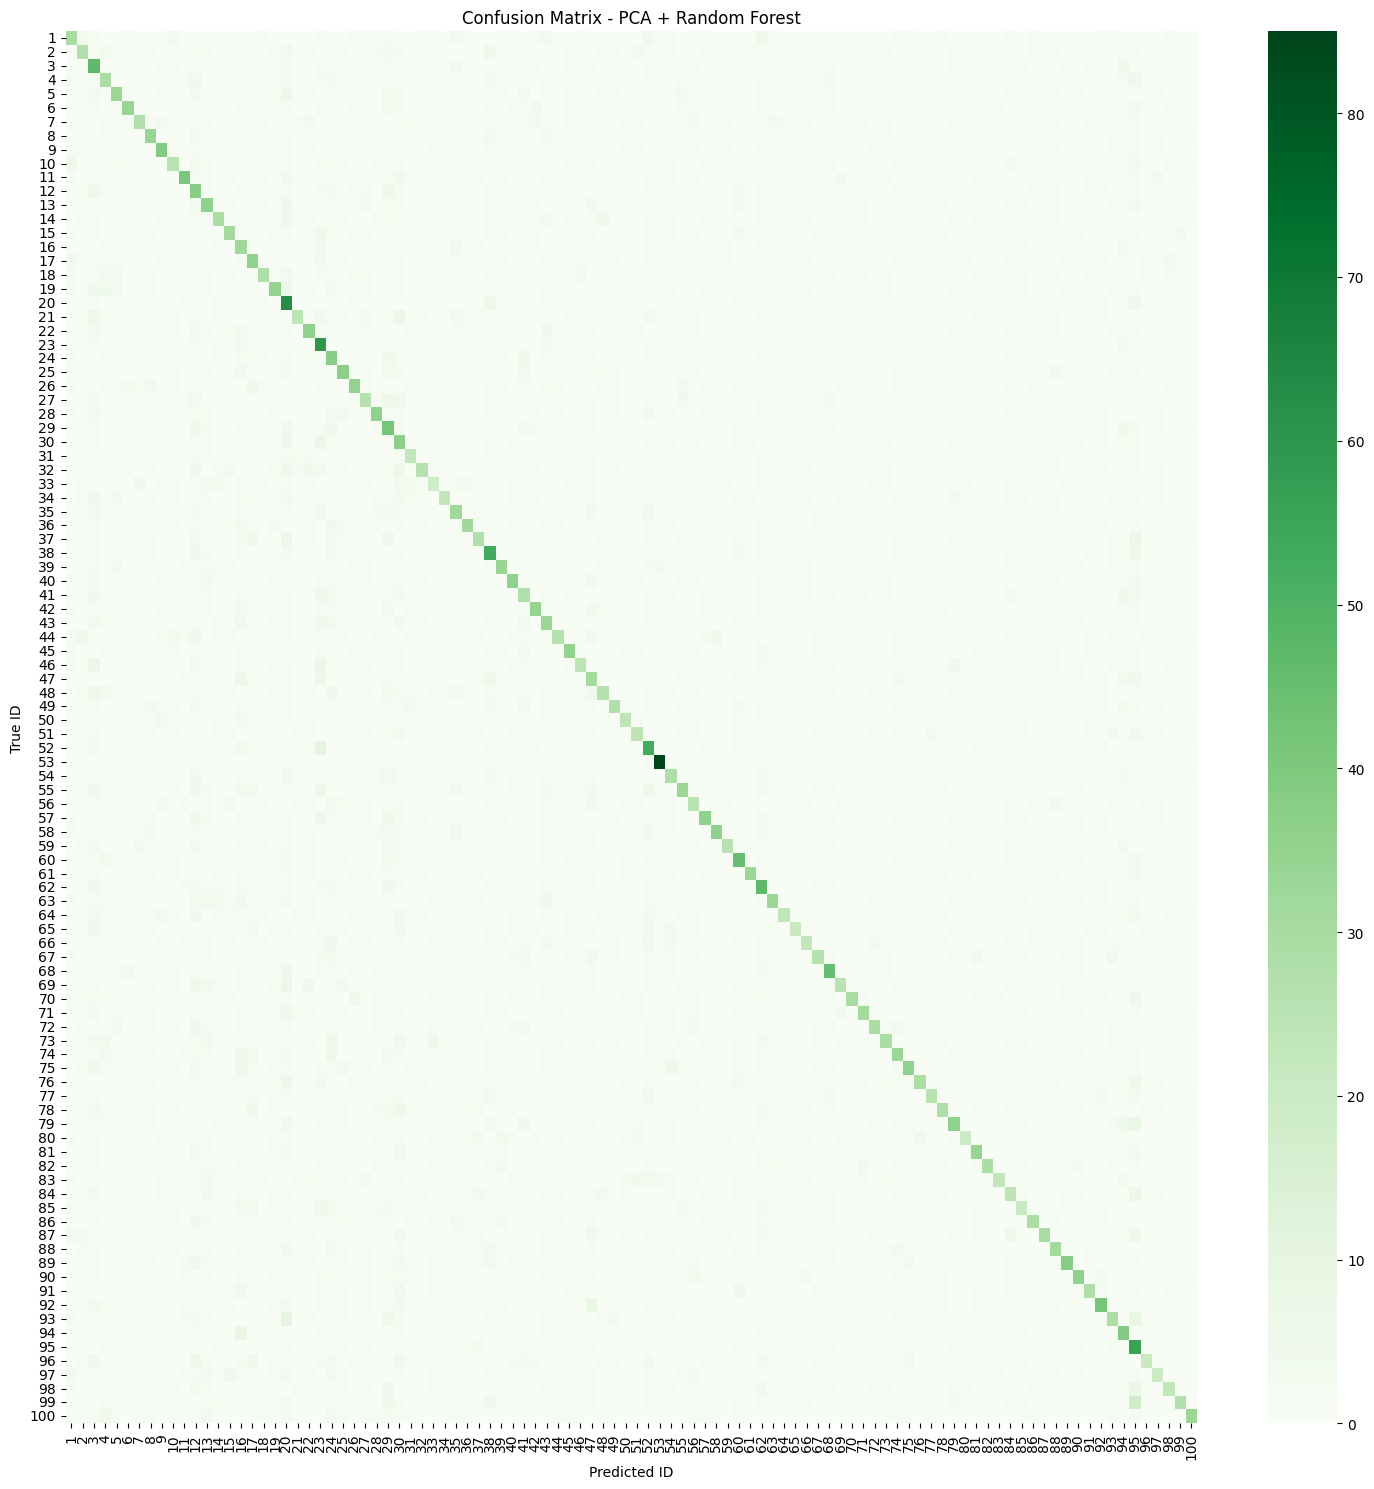

In [29]:
df_train = pd.read_csv("Fusion_features_real.csv")
df_test = pd.read_csv("Fusion_features_altered.csv")

# Fitur & Label
X_train = df_train.drop(columns=["filename", "ID"])
y_train = df_train["ID"]

X_test = df_test.drop(columns=["filename", "difficulty", "ID"])
y_test = df_test["ID"]

# 🔧 Standarisasi Fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔢 PCA
n_components = 250
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"📊 Variansi otal yang dijelaskan oleh {n_components} komponen PCA: {pca.explained_variance_ratio_.sum():.4f}")

df_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components)])
df_train_pca['ID'] = y_train.values
df_train_pca.to_csv("Train_PCA_RF.csv", index=False)

df_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(n_components)])
df_test_pca['ID'] = y_test.values
df_test_pca.to_csv("Test_PCA_RF.csv", index=False)

# ======================= Parameter Random Forest Model 🌲 ===========================
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1 # Semua Core CPU
)

model.fit(X_train_pca, y_train)

# 🔮 Prediksi
y_pred = model.predict(X_test_pca)

# 🎯 Evaluasi
acc = accuracy_score(y_test, y_pred)
print(f"Test accuracy (PCA + Random Forest): {acc:.4f}")

# ======================= Classification Report ===========================
print("Classification Report (PCA + Random Forest):")
print(classification_report(y_test, y_pred))

# ✅ Benar / ❌ Salah
correct = (y_pred == y_test).sum()
incorrect = (y_pred != y_test).sum()
print(f"✅ Jumlah prediksi benar: {correct}")
print(f"❌ Jumlah prediksi salah: {incorrect}")

plt.figure(figsize=(15, 15))
cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
sns.heatmap(cm, annot=False, cmap='Greens',
            xticklabels=sorted(y_test.unique()),
            yticklabels=sorted(y_test.unique()))
plt.xlabel("Predicted ID")
plt.ylabel("True ID")
plt.title("Confusion Matrix - PCA + Random Forest")
plt.tight_layout()
plt.show()

##### Easy

📊 Variansi total yang dijelaskan oleh 250 komponen PCA: 0.9478

🎯 Akurasi Test (PCA + Random Forest, easy only): 0.8222

📋 Classification Report:
              precision    recall  f1-score   support

           1       0.83      0.80      0.81        30
           2       0.75      0.80      0.77        30
           3       0.67      0.97      0.79        30
           4       0.77      0.90      0.83        30
           5       0.86      0.80      0.83        30
           6       0.87      0.90      0.89        30
           7       0.72      0.79      0.75        29
           8       0.81      0.83      0.82        30
           9       0.88      0.93      0.90        30
          10       0.82      0.77      0.79        30
          11       0.93      0.87      0.90        30
          12       0.71      0.90      0.79        30
          13       0.83      0.80      0.81        30
          14       0.90      0.90      0.90        30
          15       0.81      0.83      0.82

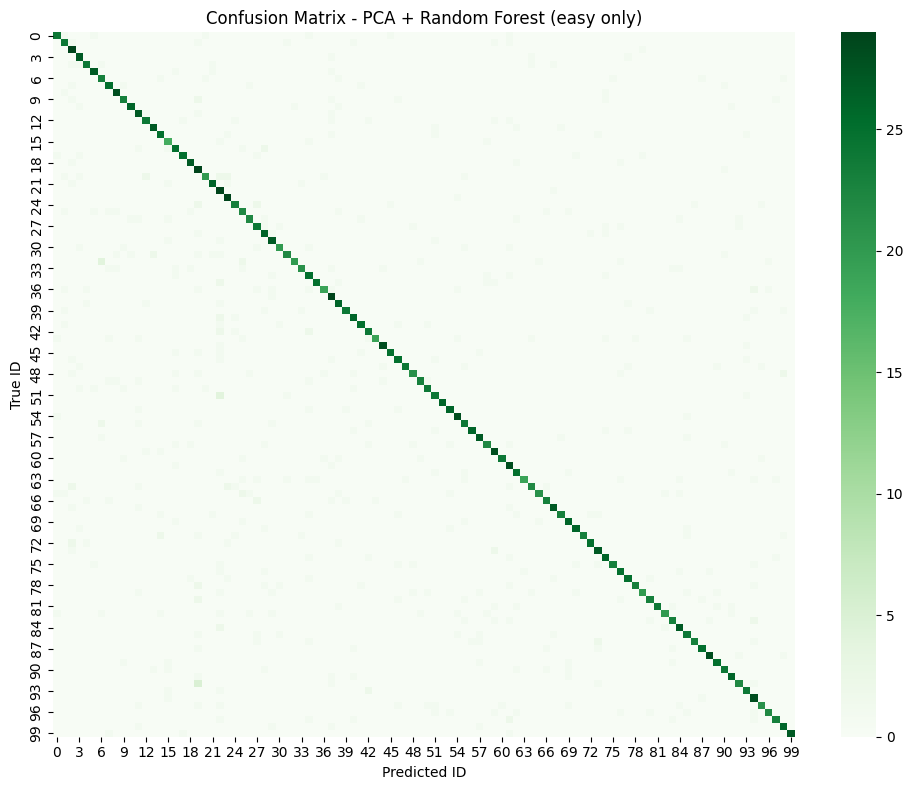

In [30]:
df_train = pd.read_csv("Fusion_features_real.csv")
df_test = pd.read_csv("Fusion_features_altered.csv")

# 🔍 Filter Test Data: difficulty = 'easy'
df_test_easy = df_test[df_test["difficulty"] == "easy"].copy()

# Fitur & Label
X_train = df_train.drop(columns=["filename", "ID"])
y_train = df_train["ID"]

X_test = df_test_easy.drop(columns=["filename", "difficulty", "ID"])
y_test = df_test_easy["ID"]

# 🔧 Standarisasi Fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 🔢 PCA
n_components = 250
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"📊 Variansi total yang dijelaskan oleh {n_components} komponen PCA: {pca.explained_variance_ratio_.sum():.4f}")

# 💾 Simpan hasil PCA
# df_train_pca = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(n_components)])
# df_train_pca['ID'] = y_train.values
# df_train_pca.to_csv("Train_PCA_easy_RF.csv", index=False)

# df_test_pca = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(n_components)])
# df_test_pca['ID'] = y_test.values
# df_test_pca.to_csv("Test_PCA_easy_RF.csv", index=False)

# 🌲 Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1 # Semua core CPU
)
rf_model.fit(X_train_pca, y_train)

# 🔮 Prediksi
y_pred = rf_model.predict(X_test_pca)

# 🎯 Evaluasi
acc = accuracy_score(y_test, y_pred)
print(f"\n🎯 Akurasi Test (PCA + Random Forest, easy only): {acc:.4f}")

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

# ✅ Benar / ❌ Salah
correct = (y_pred == y_test).sum()
incorrect = (y_pred != y_test).sum()
print(f"✅ Jumlah prediksi benar: {correct}")
print(f"❌ Jumlah prediksi salah: {incorrect}")

# 🔷 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap='Greens')
plt.title("Confusion Matrix - PCA + Random Forest (easy only)")
plt.xlabel("Predicted ID")
plt.ylabel("True ID")
plt.tight_layout()
plt.show()

# **Identifikasi Sidik Jari**

### Eksplorasi Gambar

# Pre-processing (CLAHE → Dilation → Erosion → Morphological Closing)

In [41]:
def PreprocessingImage(img_path, show=True):
    img = cv.imread(img_path)
    if img is None:
        print(f"Gagal memuat gambar: {img_path}")
        return None

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    kernel = np.ones((2, 2), np.uint8)
    dilated = cv.dilate(enhanced, kernel, iterations=1)
    eroded = cv.erode(dilated, kernel, iterations=1)
    closed = cv.morphologyEx(eroded, cv.MORPH_CLOSE, kernel)

    name_wo_ext = os.path.splitext(os.path.basename(img_path))[0]
    processed_path = f"{name_wo_ext}_processed.png"
    cv.imwrite(processed_path, closed)  # 🟢

    difference_2 = cv.absdiff(gray, enhanced)
    difference_3 = cv.absdiff(enhanced, closed)
    difference_4 = cv.absdiff(gray, closed)
    difference_final = cv.absdiff(difference_3, difference_4)
    difference_extra = cv.absdiff(difference_2, difference_final)

    print("Difference Array Shape:", difference_4.shape)
    print("Difference Array (Sample 5x5):\n", difference_4[:5, :5])

    if show:
        images = [
            (gray, "Original (Gray)"),
            (closed, "Final (Closed)"),
            (difference_4, "Diff: Gray vs Closed"),
            (difference_3, "Diff: Enhanced vs Closed"),
            (enhanced, "CLAHE Enhanced"),
            (difference_2, "Diff: Gray vs Enhanced"),
            (difference_final, "Final Difference"),
            (difference_extra, "Extra Difference"),
        ]

        plt.figure(figsize=(24, 10))
        for i, (image, title) in enumerate(images, 1):
            cmap = "gray" if len(image.shape) == 2 else None
            plt.subplot(2, 4, i)
            plt.imshow(image, cmap=cmap)
            plt.title(title)
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    return processed_path

Difference Array Shape: (103, 96)
Difference Array (Sample 5x5):
 [[ 86  86  86  86  86]
 [ 86 141 141 141 141]
 [ 86 141   9   9   9]
 [ 86 141   9   9   9]
 [ 86 141   9   9   0]]


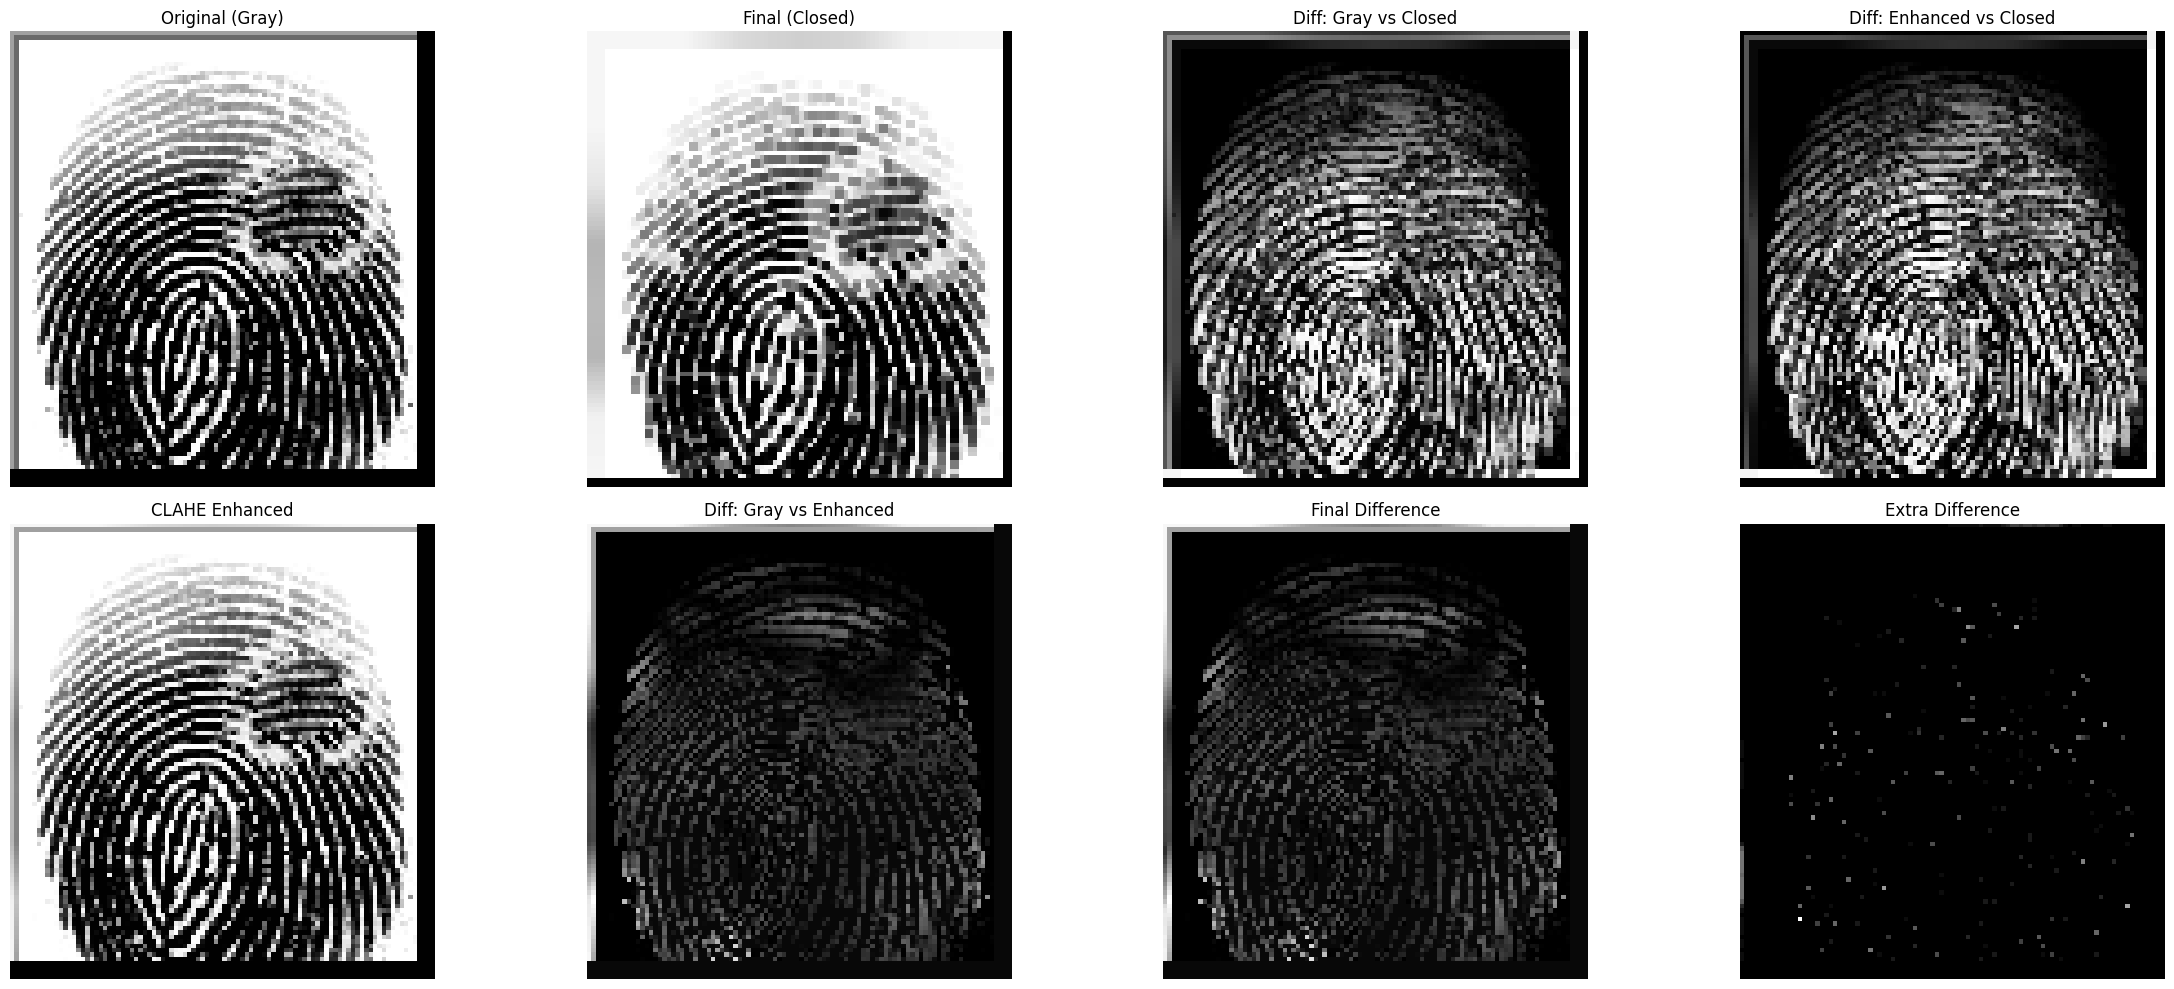

📁 Gambar hasil preprocessing disimpan di: 1__M_Left_index_finger_CR_processed.png


In [42]:
original_path = "1__M_Left_index_finger_CR.BMP"
processed_path = PreprocessingImage(original_path, show=True)

print("📁 Gambar hasil preprocessing disimpan di:", processed_path)

In [43]:
print("File exists:", os.path.exists(processed_path))  # Harus True

File exists: True


In [44]:
difficulty_label = "easy"

# Ekstraksi Fitur

##### Gabor

In [46]:
gabor_features = extract_gabor_features(processed_path)

df = pd.DataFrame([gabor_features], columns=[f'gabor_feat_{i+1}' for i in range(len(gabor_features))])
df.insert(0, "filename", processed_path)
df.insert(1, "difficulty", difficulty_label)
df.to_csv("New-GaborFeat.csv", index=False)

print("✅ Ekstraksi fitur Gabor selesai.")
print("📁 Fitur disimpan sebagai: New-GaborFeat.csv")

✅ Ekstraksi fitur Gabor selesai.
📁 Fitur disimpan sebagai: New-GaborFeat.csv


##### CNN

In [49]:
import cv2

img_size = (96, 103)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ====== Model ======
model = CustomCNN().to(device)
model.load_state_dict(torch.load("CustomCNN_FeatureExtractor.pth", map_location=device)) # Memuat arsitektur dan bobot yang sama
model.eval()

# ====== Transformasi ======
transform = transforms.ToTensor()

# ====== Load & Pre-Process Gambar ======
img = cv2.imread(processed_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Gagal membuka gambar: {processed_path}")

img = cv2.resize(img, img_size)
img_tensor = transform(img).unsqueeze(0).to(device)  # (1, 1, H, W)

# Ekstraksi Fitur
with torch.no_grad():
    cnn_features = model(img_tensor).cpu().numpy().flatten()

df = pd.DataFrame([cnn_features], columns=[f'cnn_feat_{i+1}' for i in range(len(cnn_features))])
df.insert(0, "filename", os.path.basename(processed_path))
df.insert(1, "difficulty", difficulty_label)
df.to_csv("New-CNNFeat.csv", index=False)

print("✅ Ekstraksi fitur CNN selesai.")
print("📁 Fitur disimpan sebagai: New-CNNFeat.csv")

✅ Ekstraksi fitur CNN selesai.
📁 Fitur disimpan sebagai: New-CNNFeat.csv


##### Fusion

In [50]:
df_gabor = pd.read_csv("New-GaborFeat.csv")
df_cnn = pd.read_csv("New-CNNFeat.csv")

print("📊 Ukuran Gabor:", df_gabor.shape)
print("📊 Ukuran CNN  :", df_cnn.shape)

# ==================== FUSION ====================
df_fused = pd.merge(df_gabor, df_cnn, on=["filename", "difficulty"], how="inner")

df_fused["ID"] = df_fused["filename"].apply(lambda x: x.split("__")[0])

# ==================== VALIDASI ====================
print("✅ Ukuran hasil fusion:", df_fused.shape)
print("🧾 Kolom hasil fusion:")

df_fused.to_csv("New-FusionFeat.csv", index=False)
print("📁 Fitur fusion 1 gambar disimpan → New-FusionFeat.csv")

📊 Ukuran Gabor: (1, 74)
📊 Ukuran CNN  : (1, 4098)
✅ Ukuran hasil fusion: (1, 4171)
🧾 Kolom hasil fusion:
📁 Fitur fusion 1 gambar disimpan → New-FusionFeat.csv


Validasi

In [51]:
df_fusion_all = pd.read_csv("Fusion_features_altered.csv")
df_fusion_all.shape

(8223, 4171)

### **Prediksi**

In [52]:
import joblib

# ==================== 1. Load Data & Meta ====================
df = pd.read_csv("New-FusionFeat.csv")
meta = df[["filename", "difficulty", "ID"]].copy()
X_new = df.drop(columns=["filename", "difficulty", "ID"])

# ==================== 2. Load Model Pipeline (scaler, pca, model) ====================
pipeline = joblib.load("SVM_Fingerprint_Model.joblib")
scaler = pipeline['scaler']
pca = pipeline['pca']
model = pipeline['model']

# ==================== 3. Transformasi & Reduksi Dimensi seperti: Train Data ====================
X_scaled = scaler.transform(X_new)
X_pca = pca.transform(X_scaled)

# ==================== 4. Prediksi ====================
pred = model.predict(X_pca)
meta["Predicted_ID"] = pred
print(meta)
meta.to_csv("Prediction_Result.csv", index=False)
print("✅ Prediksi selesai → Prediction_Result.csv")

                                  filename difficulty  ID  Predicted_ID
0  1__M_Left_index_finger_CR_processed.png       easy   1             1
✅ Prediksi selesai → Prediction_Result.csv


✅ Predicted ID: 1


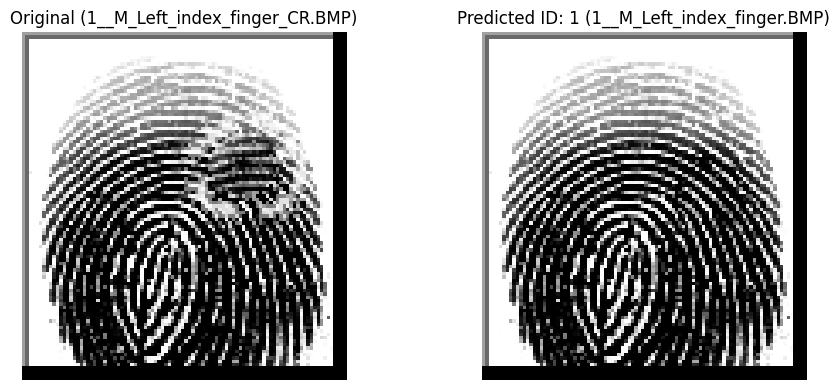

In [56]:
import joblib
import re

# ==================== 1. Setup, Load Data & Meta ====================
original_path = "1__M_Left_index_finger_CR.BMP"
folder_real = "NewSample-Real"

df = pd.read_csv("New-FusionFeat.csv")
meta = df[["filename", "difficulty", "ID"]].copy()
X_new = df.drop(columns=["filename", "difficulty", "ID"])

# ==================== 2. Load Pipeline, Transformasi, Reduksi Dimensi ====================
pipeline = joblib.load("SVM_Fingerprint_Model.joblib")
scaler = pipeline["scaler"]
pca = pipeline["pca"]
model = pipeline["model"]

X_scaled = scaler.transform(X_new)
X_pca = pca.transform(X_scaled)
pred = model.predict(X_pca)
meta["Predicted_ID"] = pred
meta.to_csv("Prediction_Result.csv", index=False)

# ==================== 3. Ekstrak Nama File Orisinal ====================
basename = os.path.basename(original_path)
base_no_ext = os.path.splitext(basename)[0]  # Hilangkan ekstensi .BMP

parts = base_no_ext.split("__")  # format: 1__M_Left_index_finger_CR
if len(parts) < 2:
    raise ValueError("Format nama file tidak valid.")

# Format Jenis Tangan & Jari, contoh: 'Left_index_finger'
finger_part = parts[1].replace("_CR", "")

# ==================== 4. Prediksi ID ====================
# Cocokkan nama file yang mengandung potongan basename (tanpa ekstensi)
match_row = meta[meta["filename"].str.contains(re.escape(base_no_ext), na=False)]

if match_row.empty:
    raise FileNotFoundError(f"Tidak ditemukan data dengan filename mengandung '{base_no_ext}' di New-FusionFeat.csv")

predicted_id = match_row["Predicted_ID"].values[0]
print(f"✅ Predicted ID: {predicted_id}")

# Referensi ID & Keterangan Jari
matching_file = None
for f in os.listdir(folder_real):
    if f.startswith(f"{predicted_id}__") and finger_part in f:
        matching_file = os.path.join(folder_real, f)
        break

if matching_file is None:
    raise FileNotFoundError(f"Tidak ditemukan gambar referensi untuk ID {predicted_id} dan jari {finger_part}")

# ==================== 5. Visual ====================
img_original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)
img_predicted = cv2.imread(matching_file, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(img_original, cmap='gray')
plt.title(f"Original ({basename})")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_predicted, cmap='gray')
plt.title(f"Predicted ID: {predicted_id} ({os.path.basename(matching_file)})")
plt.axis("off")

plt.tight_layout()
plt.show()

In [61]:
def show_topk_predictions(original_path, meta_csv_path, folder_real, top_k=3):
    basename = os.path.basename(original_path)
    # Ambil bagian jari (misal: Left_index_finger)
    finger_full = basename.split("__")[1].replace("_CR", "").replace(".BMP", "").replace(".bmp", "").replace(".png", "").replace(".jpg", "")

    # Dari finger_full, hilangkan gender (M/F) jika ada, supaya dapat matching lebih luas
    # Contoh: "M_Left_index_finger" -> "Left_index_finger"
    finger_parts = finger_full.split('_')
    if finger_parts[0] in ['M', 'F']:
        finger_part = "_".join(finger_parts[1:])
    else:
        finger_part = finger_full

    meta = pd.read_csv(meta_csv_path)
    match_row = meta[meta["filename"].str.contains(re.escape(basename.split(".")[0]), na=False)]
    if match_row.empty:
        raise FileNotFoundError(f"Tidak ditemukan data yang cocok untuk '{basename}' dalam CSV.")
    
    top_preds = []
    for i in range(1, top_k + 1):
        col_name = f"Top{i}_Pred"
        if col_name in match_row:
            top_preds.append(str(match_row[col_name].values[0]))

    img_original = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(4 + 3 * len(top_preds), 4))
    plt.subplot(1, len(top_preds)+1, 1)
    plt.imshow(img_original, cmap='gray')
    plt.title("Original\n" + basename)
    plt.axis("off")

    for idx, pred_id in enumerate(top_preds):
        matching_file = None
        for f in os.listdir(folder_real):
            # Cek prefix ID sama dan jari ada di nama file
            if f.startswith(f"{pred_id}__") and finger_part in f:
                matching_file = os.path.join(folder_real, f)
                break
        
        plt.subplot(1, len(top_preds)+1, idx+2)
        if matching_file and os.path.exists(matching_file):
            img_pred = cv2.imread(matching_file, cv2.IMREAD_GRAYSCALE)
            plt.imshow(img_pred, cmap='gray')
            plt.title(f"Top-{idx+1} Match\n{os.path.basename(matching_file)}")
        else:
            plt.text(0.5, 0.5, "Not found", ha='center', va='center', fontsize=12)
            plt.title(f"Top-{idx+1} Match\nID {pred_id}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


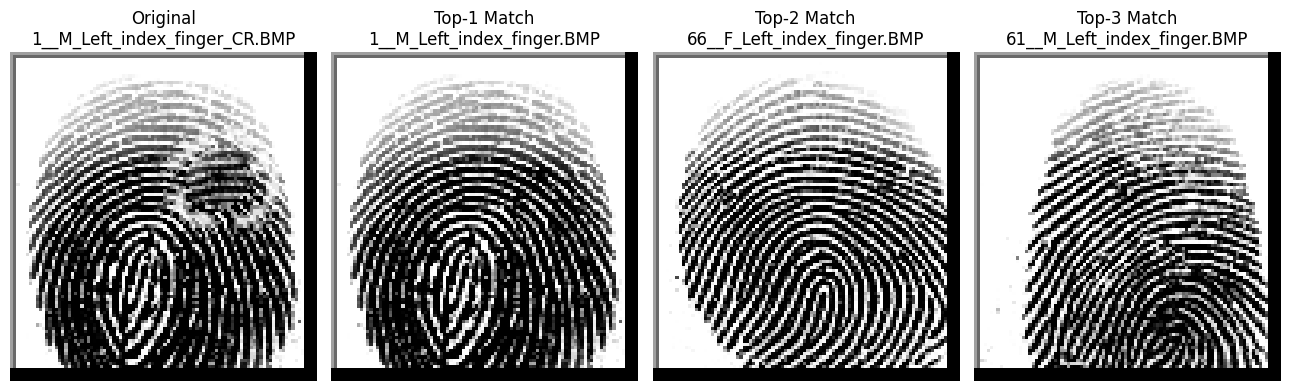

In [62]:
show_topk_predictions(
    original_path="1__M_Left_index_finger_CR.BMP",
    meta_csv_path="Prediction_Result_Top3.csv",
    folder_real="NewSample-Real",
    top_k=3
)